### Previsione del prezzo di Microsoft utilizzando i prezzi di asset correlati
Fonte: Tatsa H., Puri S., Lookabaugh B. (2021) Machine Learning & Data Science Blueprints for Finance, cap. 5

Scopo dell'esercizio è prevedere il prezzo di Microsoft utilizzando i prezzi di sette variabili finanziarie:
- Azioni: IBM e Google
- Tassi di cambio: USD/JPY, GBP/USD 
- Indici di mercato: S&P 500, Dow Jones, VIX

I dati sono scaricati dal sito di Yahoo Finance e dal db FRED della Federal Reserve Bank of Saint Louis.

Utilizziamo i prezzi giornalieri dal 1.1.2010 al giorno dell'analisi


#### 1. Caricamento delle librerie

Funzioni e moduli per preparazione e visualizzazione dei dati

In [52]:
from datetime import date, datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
import warnings

Funzioni e moduli per i modelli di regressione

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

Funzioni e moduli per analisi dei dati e valutazione dei modelli

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

Funzioni e moduli per i modelli la rete neurale

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

Funzioni e moduli per serie temporali

In [58]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

#### 2. Caricamento dei dati

In [59]:
stk_tickers = ['MSFT', 'IBM','GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['^GSPC','^DJI','^VIX']

In [60]:
start_date = '2010-01-01'
end_date = datetime.today()

In [64]:
stk_data = web.DataReader(stk_tickers,'yahoo', start_date, end_date)
ccy_data = web.DataReader(ccy_tickers,'fred', start_date, end_date)
idx_data = web.DataReader(idx_tickers,'yahoo', start_date, end_date)

In [65]:
idx_data.head(100)

Attributes    Adj Close                                 Close                \
Symbols           ^GSPC          ^DJI       ^VIX        ^GSPC          ^DJI   
Date                                                                          
2010-01-04  1132.989990  10583.959961  20.040001  1132.989990  10583.959961   
2010-01-05  1136.520020  10572.019531  19.350000  1136.520020  10572.019531   
2010-01-06  1137.140015  10573.679688  19.160000  1137.140015  10573.679688   
2010-01-07  1141.689941  10606.860352  19.059999  1141.689941  10606.860352   
2010-01-08  1144.979980  10618.190430  18.129999  1144.979980  10618.190430   
...                 ...           ...        ...          ...           ...   
2010-05-20  1071.589966  10068.009766  45.790001  1071.589966  10068.009766   
2010-05-21  1087.689941  10193.389648  40.099998  1087.689941  10193.389648   
2010-05-24  1073.650024  10066.570312  38.320000  1073.650024  10066.570312   
2010-05-25  1074.030029  10043.750000  34.610001  1074.030029  10043.750000   
2010-05-26  1067.949951   9974.450195  35.020000  1067.949951   9974.450195   

Attributes                    High                                   Low  \
Symbols          ^VIX        ^GSPC          ^DJI       ^VIX        ^GSPC   
Date                                                                       
2010-01-04  20.040001  1133.869995  10604.969727  21.680000  1116.560059   
2010-01-05  19.350000  1136.630005  10584.559570  20.129999  1129.660034   
2010-01-06  19.160000  1139.189941  10594.990234  19.680000  1133.949951   
2010-01-07  19.059999  1142.459961  10612.370117  19.709999  1131.319946   
2010-01-08  18.129999  1145.390015  10619.400391  19.270000  1136.219971   
...               ...          ...           ...        ...          ...   
2010-05-20  45.790001  1107.339966  10440.209961  46.369999  1071.579956   
2010-05-21  40.099998  1090.160034  10198.530273  48.200001  1055.900024   
2010-05-24  38.320000  1089.949951  10196.410156  41.740002  1072.699951   
2010-05-25  34.610001  1074.750000  10061.660156  43.740002  1040.780029   
2010-05-26  35.020000  1090.750000  10179.030273  35.020000  1065.589966   

Attributes                                  Open                           \
Symbols             ^DJI       ^VIX        ^GSPC          ^DJI       ^VIX   
Date                                                                        
2010-01-04  10430.690430  20.030001  1116.560059  10430.690430  21.680000   
2010-01-05  10522.519531  19.340000  1132.660034  10584.559570  20.049999   
2010-01-06  10546.549805  18.770000  1135.709961  10564.719727  19.590000   
2010-01-07  10505.209961  18.700001  1136.270020  10571.110352  19.680000   
2010-01-08  10554.330078  18.110001  1140.520020  10606.400391  19.270000   
...                  ...        ...          ...           ...        ...   
2010-05-20  10065.360352  40.299999  1107.339966  10440.209961  41.790001   
2010-05-21   9918.820312  38.950001  1067.260010  10063.929688  47.660000   
2010-05-24  10052.669922  35.570000  1084.780029  10193.459961  41.740002   
2010-05-25   9774.480469  34.590000  1067.420044  10061.429688  43.150002   
2010-05-26   9952.679688  24.100000  1075.510010  10045.110352  32.540001   

Attributes      Volume                  
Symbols          ^GSPC       ^DJI ^VIX  
Date                                    
2010-01-04  3991400000  179780000    0  
2010-01-05  2491020000  188540000    0  
2010-01-06  4972660000  186040000    0  
2010-01-07  5270680000  217390000    0  
2010-01-08  4389590000  172710000    0  
...                ...        ...  ...  
2010-05-20  8328570000  360350000    0  
2010-05-21  5452130000  438220000    0  
2010-05-24  5224040000  211430000    0  
2010-05-25  7329580000  316960000    0  
2010-05-26  4521050000  316080000    0  

[100 rows x 18 columns]

Prepariamo i dati ritardati

Utilizziamo i dati ritardati di 5 giorni di tutte le variabili indipendenti e i valori ritardati di 5, 15, 30 e 60 giorni di MSFT

In [67]:
return_period = 5
Y = np.log(stk_data.loc[:,('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

In [68]:
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL','IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data['Adj Close']).diff(return_period)
X4 = pd.concat([np.log(stk_data.loc[:,('Adj Close','MSFT')]).diff(i)\
                for i in [return_period, return_period*3,\
                         return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT','MSFT_6DT','MSFT_12DT']
X = pd.concat([X1,X2, X3, X4], axis = 1)

In [69]:
dataset = pd.concat([Y,X], axis=1).dropna().iloc[::return_period,:]
Y = dataset.loc[:,Y.name]
X = dataset.loc[:,X.columns]

#### 3. Analisi esplorativa dei dati

In [70]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,^GSPC,^DJI,^VIX,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2010-03-31,0.021281,0.017413,-0.002181,0.016299,0.018074,0.001463,0.001888,0.002277,-0.012216,0.010985,0.024189,-0.050461
2010-04-08,0.031258,0.000652,-0.005003,-0.007166,-0.001178,0.014441,0.006467,-0.065183,0.021281,0.009740,0.044072,-0.006965
2010-04-15,0.016705,0.047842,0.025379,-0.001289,0.012558,0.021042,0.019709,-0.036457,0.031258,0.040323,0.081285,-0.002758
2010-04-22,-0.012502,-0.084507,-0.013538,-0.000322,-0.006292,-0.002479,-0.000923,0.035851,0.016705,0.069243,0.080228,0.066765
2010-04-29,-0.067381,-0.027915,0.010247,0.012288,-0.004239,-0.001565,0.002962,0.112982,-0.012502,0.035460,0.045200,0.090153


In [71]:
dataset.tail()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,^GSPC,^DJI,^VIX,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2021-11-24,-0.025234,-0.013102,-0.011329,0.008795,-0.011633,0.002724,-0.003532,0.082423,-0.003574,0.013466,0.133201,0.114578
2021-12-03,0.058705,-0.001277,0.025827,-0.005125,-0.006628,-0.012305,-0.009190,0.069179,-0.020439,-0.026918,0.040490,0.084938
2021-12-10,-0.056262,0.041385,0.043229,0.004243,0.002114,0.037536,0.039435,-0.495296,0.058705,0.003715,0.056393,0.117183
2021-12-17,0.056000,-0.043334,0.026325,0.001763,0.000528,-0.019583,-0.016978,0.143315,-0.056262,-0.017996,-0.036466,0.079639
2021-12-27,-0.022742,0.042692,0.032587,0.012265,0.016204,0.036246,0.026148,-0.198869,0.056000,0.058442,0.031524,0.196330


In [72]:
dataset.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,^GSPC,^DJI,^VIX,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000
mean,0.004458,0.003845,0.000790,0.000561,-0.000302,0.002437,0.002185,-0.001326,0.004928,0.013644,0.027333,0.052903
std,0.033653,0.035748,0.031803,0.012481,0.012113,0.023868,0.023932,0.169105,0.033803,0.053007,0.068244,0.088874
min,-0.155315,-0.131259,-0.173146,-0.052258,-0.066158,-0.140676,-0.166713,-0.556225,-0.155315,-0.239569,-0.299103,-0.237439
25%,-0.014221,-0.016349,-0.013444,-0.005985,-0.007213,-0.006340,-0.007382,-0.093729,-0.012580,-0.013835,-0.013559,-0.002406
50%,0.005147,0.005186,0.003146,0.000660,-0.000187,0.005197,0.004328,-0.016529,0.006046,0.017098,0.030004,0.061073
75%,0.023525,0.024227,0.017740,0.007653,0.007355,0.014397,0.013235,0.081320,0.022894,0.047071,0.069085,0.112372
max,0.164103,0.174206,0.175315,0.058289,0.075400,0.160395,0.183091,0.960131,0.164103,0.244822,0.284663,0.283020


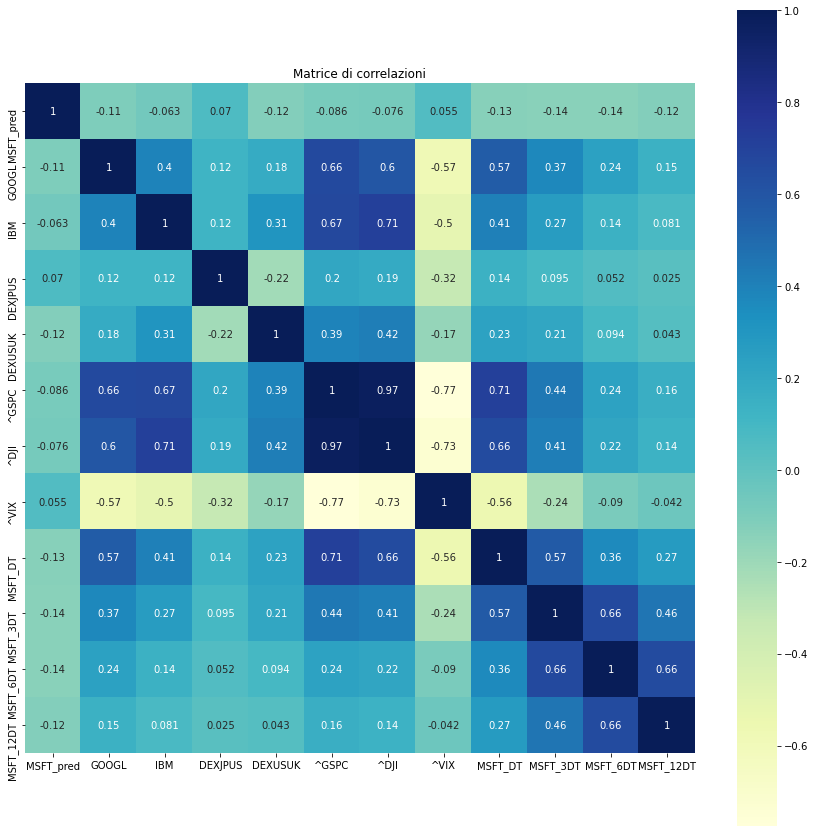

In [73]:
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Matrice di correlazioni')
sns.heatmap(correlation, vmax=1, square=True,annot=True, cmap="YlGnBu");

<Figure size 1080x1080 with 0 Axes>

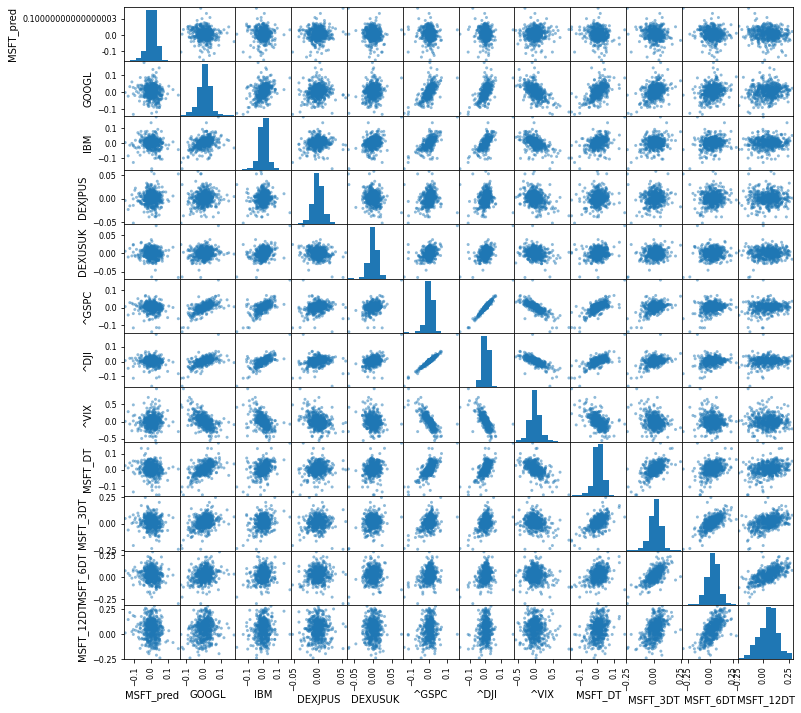

In [74]:
plt.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
plt.show()

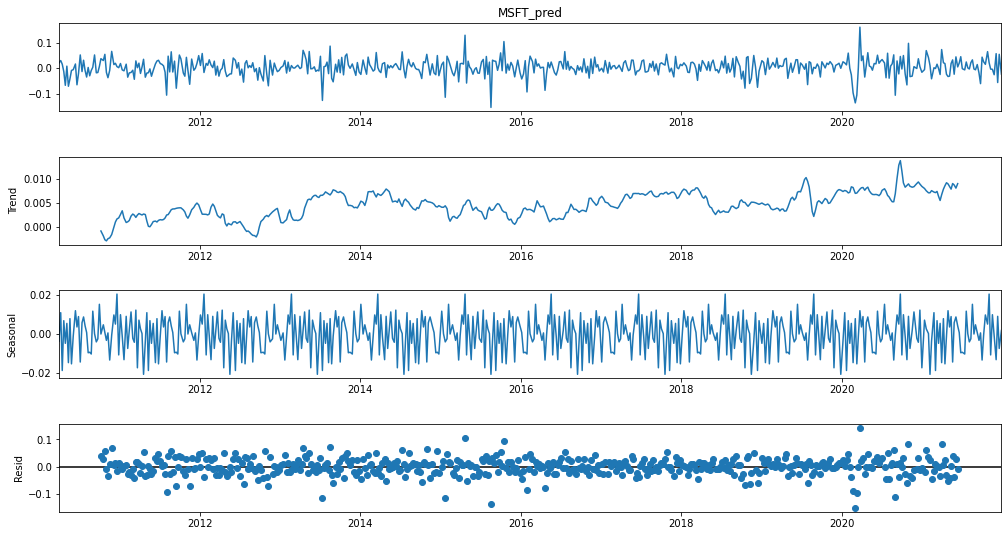

In [75]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig=res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

#### 4. Preparazione dei dati
In questo caso non necessaria

#### 5. Valutazione dei modelli

Creazione dei dataset di addestramento e validazione

In [76]:
validation_size = 0.2
train_size = int(len(X)*(1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

Numero dei test e metrica di valutazione

In [77]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

Selezione del modello migliore

Regressione

In [78]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
#models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

Rete neurale

In [79]:
models.append(('MLP', MLPRegressor()))

Confronto degli algoritmi

Calcoliamo media e deviazioe standard delle metriche di valutazione delle 10 validazioni con ricampionamento (K-fold cross validation)

In [80]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=10,shuffle = True)
    #converted mean square error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001004 (0.000332) 0.000950 0.001695
LASSO: 0.001004 (0.000302) 0.001003 0.001643
EN: 0.001004 (0.000302) 0.001003 0.001643
KNN: 0.001204 (0.000236) 0.000749 0.001864
SVR: 0.001860 (0.000431) 0.001789 0.002672
MLP: 0.001064 (0.000296) 0.000988 0.001613


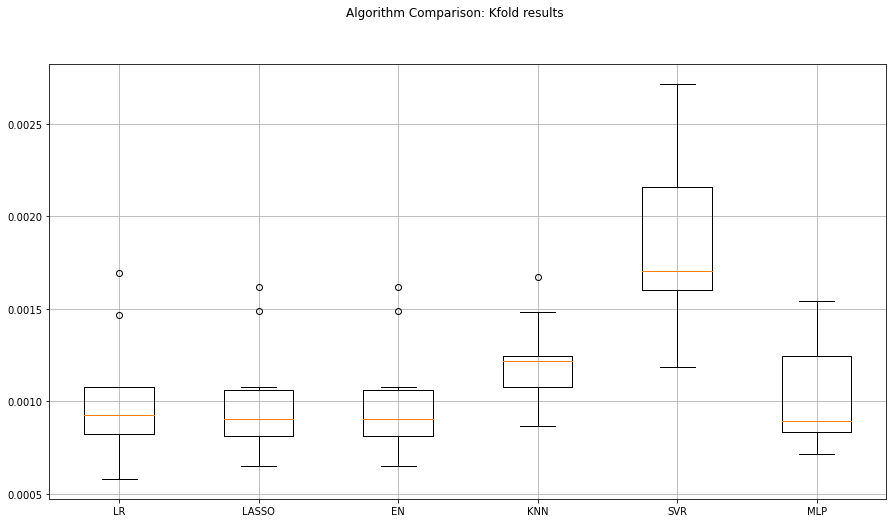

In [32]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.grid(True)
plt.show()

Confronto fra l'errore nell'addestramento e nella validazione

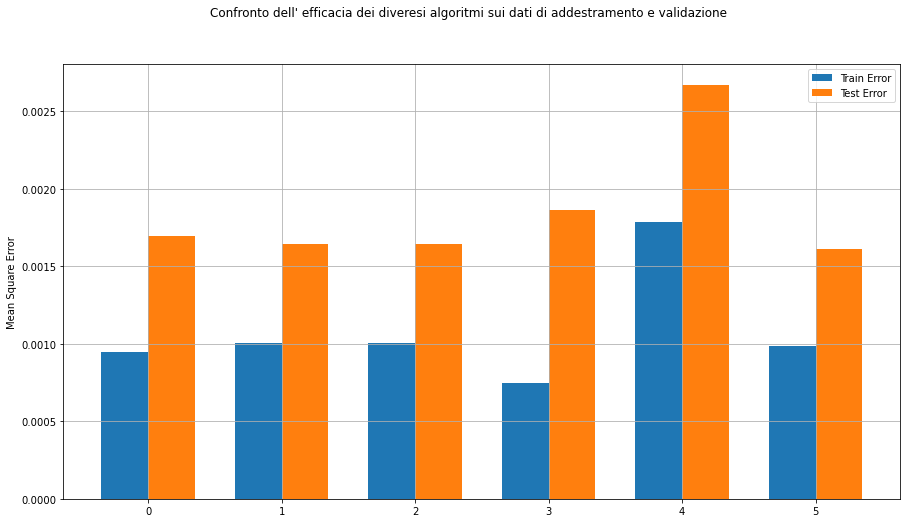

In [81]:
fig = plt.figure()
ind = np.arange(len(names)) #posizione dei singoli confronti
width = 0.35 # larghezza delle barre
fig.suptitle("Confronto dell' efficacia dei diveresi algoritmi sui dati di addestramento e validazione")
#ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.grid(True)
plt.ylabel('Mean Square Error')
plt.show()

#### 6. Confronto con ARIMAX

In [82]:
X_train_ARIMA = X_train.loc[:,['IBM','GOOGL','DEXJPUS', 'DEXUSUK', '^GSPC','^DJI','^VIX']]
X_test_ARIMA = X_test.loc[:,['IBM','GOOGL','DEXJPUS', 'DEXUSUK', '^GSPC','^DJI','^VIX']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

Poiché vogliamo utilizzare variabili esogene il modello scelto è ARIMAX

In [83]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [84]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0016826931438968455

In [85]:
test_results.append(error_Test_ARIMA)
train_results.append(error_Training_ARIMA)
names.append('ARIMA')

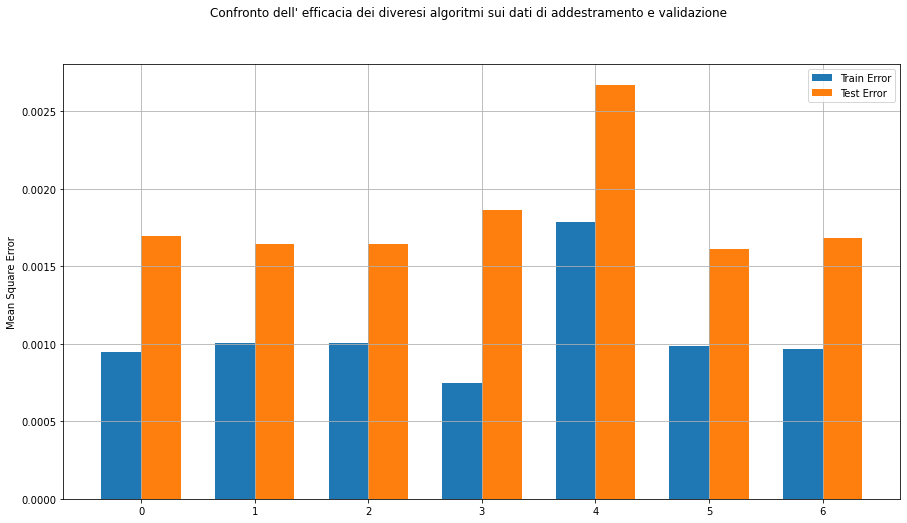

In [86]:
fig = plt.figure()
ind = np.arange(len(names)) #posizione dei singoli confronti
width = 0.35 # larghezza delle barre
fig.suptitle("Confronto dell' efficacia dei diveresi algoritmi sui dati di addestramento e validazione")
#ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('Mean Square Error')
plt.grid(True)
plt.show()

#### 7. Ottimizzazione degli iperparametri di ARIMAX

In [95]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)   

ARIMA(0, 0, 0) MSE=0.0009723
ARIMA(0, 0, 1) MSE=0.0009630
ARIMA(1, 0, 0) MSE=0.0009636
ARIMA(1, 0, 1) MSE=0.0009625
ARIMA(2, 0, 0) MSE=0.0009632
ARIMA(2, 0, 1) MSE=0.0009516
Best ARIMA(2, 0, 1) MSE=0.0009516


In [96]:
# prepare model
modelARIMA_tuned=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,1])
model_fit_tuned = modelARIMA_tuned.fit()

In [97]:
# estimate accuracy on validation set
predicted_tuned = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
print(mean_squared_error(Y_test,predicted_tuned))

0.0016826931438968455


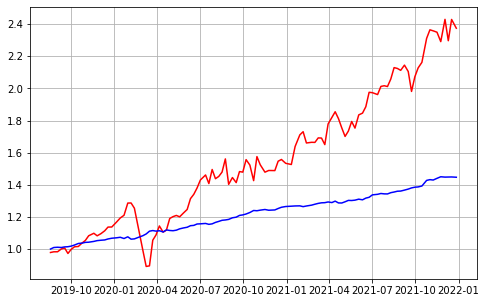

In [98]:
#Use the following code to produce the comparison of actual vs. predicted
predicted_tuned.index = Y_test.index
plt.plot(np.exp(Y_test).cumprod(), 'r') # plotting t, a separately
plt.plot(np.exp(predicted_tuned).cumprod(), 'b')
plt.rcParams["figure.figsize"] = (8,5)
plt.grid(True)
plt.show()